# Simulator to compare OM with TD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


@interact(alpha = widgets.FloatSlider(min=0.001,max=0.499,step=0.001,value=0.001), 
          beta = widgets.FloatSlider(min=0.001,max=0.499,step=0.001,value=0.001), 
          var_a = widgets.FloatSlider(min=0,max=5,step=0.01,value=1),
          var_b = widgets.FloatSlider(min=0,max=5,step=0.01,value=1),
          corr = widgets.FloatSlider(min=-1,max=1,step=0.01,value=0),
          size_u = widgets.IntSlider(min=1,max=1000,step=1,value=1000),
          size_t = widgets.IntSlider(min=1,max=1000,step=1,value=1000),
          target = widgets.FloatSlider(min=0.01,max=1,step=0.01,value=0.05),
          sim_size = widgets.IntSlider(min=1000,max=1000000,step=1000,value=100000))
def compare_methods(alpha=0.001, beta=0.001, var_a=1, var_b=1, corr=0, size_u=1000, size_t=1000, target=0.05, sim_size=10000,
                   print_on=True):
    # Set mean and covariance for the random variables
    e_b = beta * (1+alpha/(1-alpha))/(1 - beta * (1+alpha/(1-alpha)))
    mean_b = np.log(e_b) 
    mean_a = np.log(alpha*(1+e_b)/(1-alpha))
    cov = corr * np.sqrt(var_a) * np.sqrt(var_b)
    # Generate probabilities for Sure Things and Persuadables
    exps = np.exp(np.random.multivariate_normal([mean_a, mean_b], [[var_a, cov], [cov, var_b]], sim_size))
    probs_a = exps[:, 0] / (exps.sum(axis=1) + 1.0)
    probs_b = exps[:, 1] / (exps.sum(axis=1) + 1.0)
    # Probabilities for the treated and untreated
    y_t = probs_a + probs_b
    y_u = probs_a
    # Generate probability estimates
    scores_u = np.random.beta(y_u * size_u, (1-y_u) * size_u)
    scores_t = np.random.beta(y_t * size_t, (1-y_t) * size_t)
    # Generate rankings
    opt_ranking = probs_b.argsort().argsort()
    om_ranking = (scores_t).argsort().argsort()
    td_ranking = (scores_t - scores_u).argsort().argsort()
    # Evaluate what percent of the top observations matches the top in the optimal
    rank_threshold = sim_size*(1-target)
    om_match = (opt_ranking[om_ranking >= rank_threshold] >= rank_threshold).mean()
    td_match = (opt_ranking[td_ranking >= rank_threshold] >= rank_threshold).mean()
    # Evaluate in terms of expected number of people persuaded
    om_val = probs_b[om_ranking >= rank_threshold].sum()
    td_val = probs_b[td_ranking >= rank_threshold].sum()    
    if print_on:
        print("Match between the top {0}% of OM and the optimal model: {1:.2f}%".format(target*100, om_match*100))
        print("Match between the top {0}% of TD and the optimal model: {1:.2f}%".format(target*100, td_match*100))
        if om_match >= td_match:
            print("Winner in match: OM")
        else:
            print("Winner in match: TD")
        print("Difference in match:{0:.2f}%".format(np.abs(td_match-om_match)*100))
        print("=========")
        print("Individuals persuaded by OM: {1:.2f}".format(target*100, om_val))
        print("Individuals persuaded by TD: {1:.2f}".format(target*100, td_val))
        if om_val >= td_val:
            print("Winner in individuals: OM")
        else:
            print("Winner in individuals: TD")
        print("Difference in individuals:{0:.2f}".format(np.abs(td_val-om_val)))
    return [om_match, td_match, om_val, td_val]

# Setting 1: Uniform bias
Values: var_a=0, var_b=2, move alpha. OM should always win

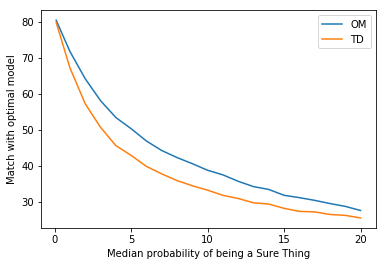

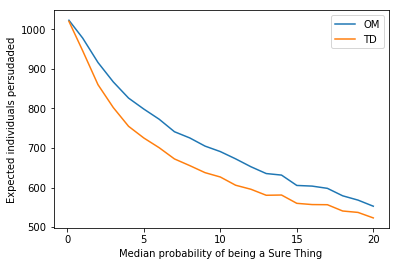

In [2]:
def draw_graph(x_points, tick_range, xlabel, args, arg_name, mul=True):
    # Simulate data
    results = []
    for x in x_points:
        args[arg_name] = x
        results.append(compare_methods(**args))
    results = np.array(results)
    results[:, 0] *= 100
    results[:, 1] *= 100
    if mul:
        x_points *= 100
    # Draw graphs
    om_match, td_match, om_val, td_val = results[:,0], results[:,1], results[:,2], results[:,3]
    plt.plot(x_points, om_match, label="OM")
    plt.plot(x_points, td_match, label="TD")
    plt.ylabel("Match with optimal model")
    plt.xlabel(xlabel)
    plt.xticks(tick_range)
    plt.legend()
    plt.show()
    plt.plot(x_points, om_val, label="OM")
    plt.plot(x_points, td_val, label="TD")
    plt.ylabel("Expected individuals persudaded")
    plt.xlabel(xlabel)
    plt.xticks(tick_range)
    plt.legend()
    plt.show()
    
alphas = np.array([0.1] + list(range(1, 21))) * 0.01
ticks = np.arange(0, 25, 5)
label = "Median probability of being a Sure Thing"
args = {"sim_size":1000000, "var_a": 0, "var_b": 2, "print_on": False}
arg_name = "alpha"
draw_graph(alphas, ticks, label, args, arg_name)

# Setting 2: Small training data
Values: var_a=0.2, var_b=2, alpha=0.1, beta=0.1, move size_u. OM should win if size_u is small

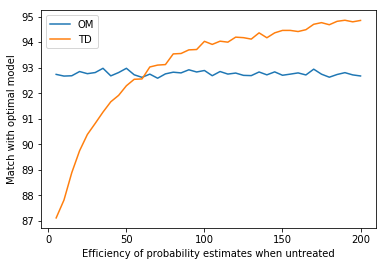

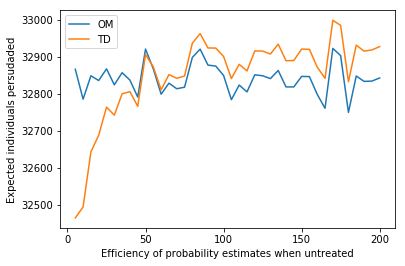

In [3]:
sizes_u = np.array(range(5, 205, 5))
ticks = np.arange(0, 250, 50)
label = "Efficiency of probability estimates when untreated"
args = {"sim_size":1000000, "var_a": 0.2, "var_b": 2, "alpha":0.1, "beta":0.1, "print_on": False}
arg_name = "size_u"
draw_graph(sizes_u, ticks, label, args, arg_name, mul=False)

# Setting 3: Correlated outcomes and effects
Values: alpha=0.1, move corr. OM should win if correlation is large

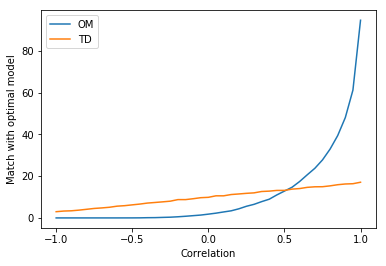

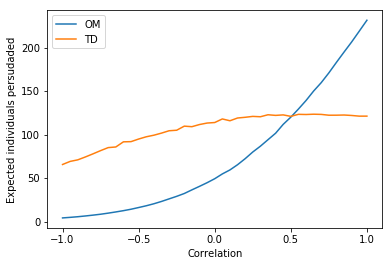

In [4]:
corrs = np.array(range(-100, 105, 5)) * 0.01
ticks = np.arange(-1, 1.5, 0.5)
label = "Correlation"
args = {"sim_size":1000000, "alpha":0.1, "print_on": False}
arg_name = "corr"
draw_graph(corrs, ticks, label, args, arg_name, mul=False)

# Setting 4: High prediction certainty
Values: corr: 0.4, size_u = 100, move target. OM should win if target is large.

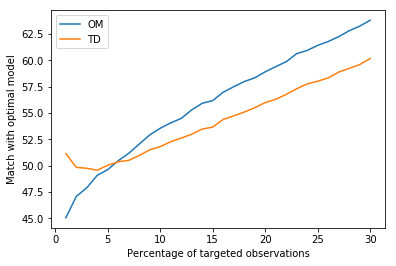

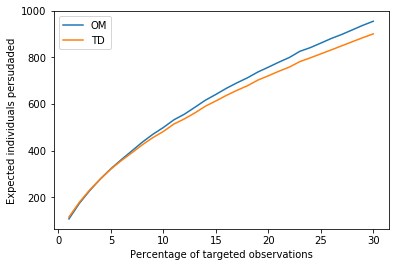

In [5]:
targets = np.array(range(1, 31)) * 0.01
ticks = np.arange(0, 35, 5)
label = "Percentage of targeted observations"
args = {"sim_size":1000000, "corr":0.4, "size_u":100, "print_on": False}
arg_name = "target"
draw_graph(targets, ticks, label, args, arg_name)

# Setting 5: Non-uniform uncorrelated bias
Move size_u. OM should always lose.

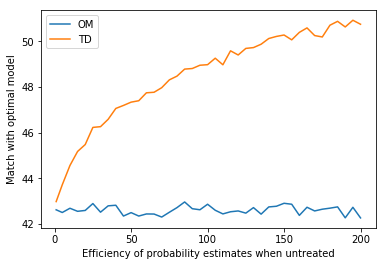

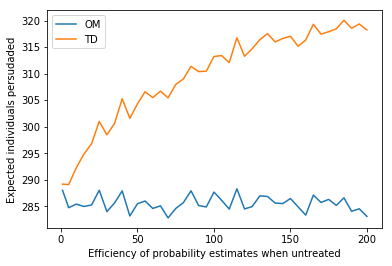

In [6]:
sizes_u = np.array([1] + list(range(5, 205, 5)))
ticks = np.arange(0, 250, 50)
label = "Efficiency of probability estimates when untreated"
args = {"sim_size":1000000, "print_on": False}
arg_name = "size_u"
draw_graph(sizes_u, ticks, label, args, arg_name, mul=False)

# Robustness check: variance in counterfactuals
The increase in performance of using treatment effects depends on the variance of the "untreated" probabilities.

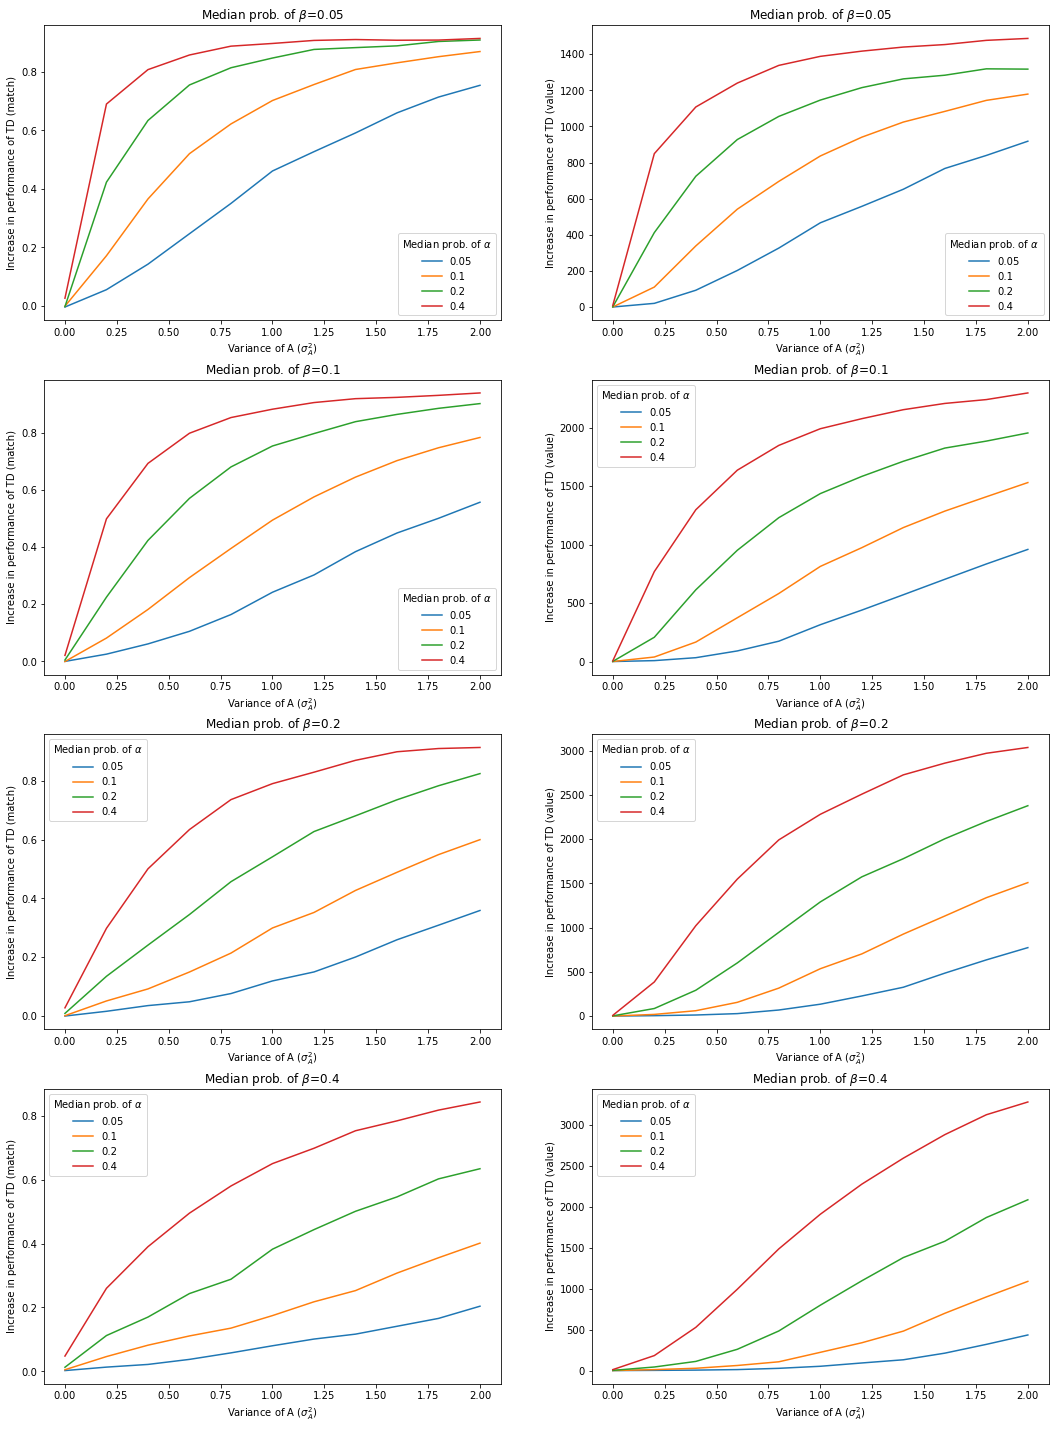

In [7]:
def do_robustness_check(arg_name, x_points, xlabel):
    args = {"sim_size": 100000, "print_on": False}
    alpha_arr = [0.05, 0.1, 0.2, 0.4]
    beta_arr = [0.05, 0.1, 0.2, 0.4]
    fig, axes = plt.subplots(4, 2, figsize=(18,25))
    for i, beta in enumerate(beta_arr):
        row = i
        args["beta"] = beta
        for alpha in alpha_arr:
            args["alpha"] = alpha
            performance_match = []
            performance_value = []
            for x in x_points:
                args[arg_name] = x
                results = compare_methods(**args)
                performance_match.append(results[1] - results[0])
                performance_value.append(results[3] - results[2])
            axes[row, 0].plot(x_points, performance_match, label="{0}".format(alpha))
            axes[row, 1].plot(x_points, performance_value, label="{0}".format(alpha))
        t = r'Median prob. of $\alpha$'
        axes[row, 0].legend(title=t)
        axes[row, 1].legend(title=t)
        t = r'Median prob. of $\beta$={0}'
        axes[row, 0].set_title(t.format(beta))
        axes[row, 0].set_xlabel(xlabel)
        axes[row, 0].set_ylabel("Increase in performance of TD (match)")
        axes[row, 1].set_title(t.format(beta))
        axes[row, 1].set_xlabel(xlabel)
        axes[row, 1].set_ylabel("Increase in performance of TD (value)")
    plt.subplots_adjust(hspace=0.2)
    plt.show()

do_robustness_check("var_a", np.array(range(11)) * 0.2, r'Variance of A ($\sigma_A^2$)')

# Robustness check: variance in counterfactual estimates
The increase in performance of using treatment effects depends on the variance of the "untreated" probability estimates.

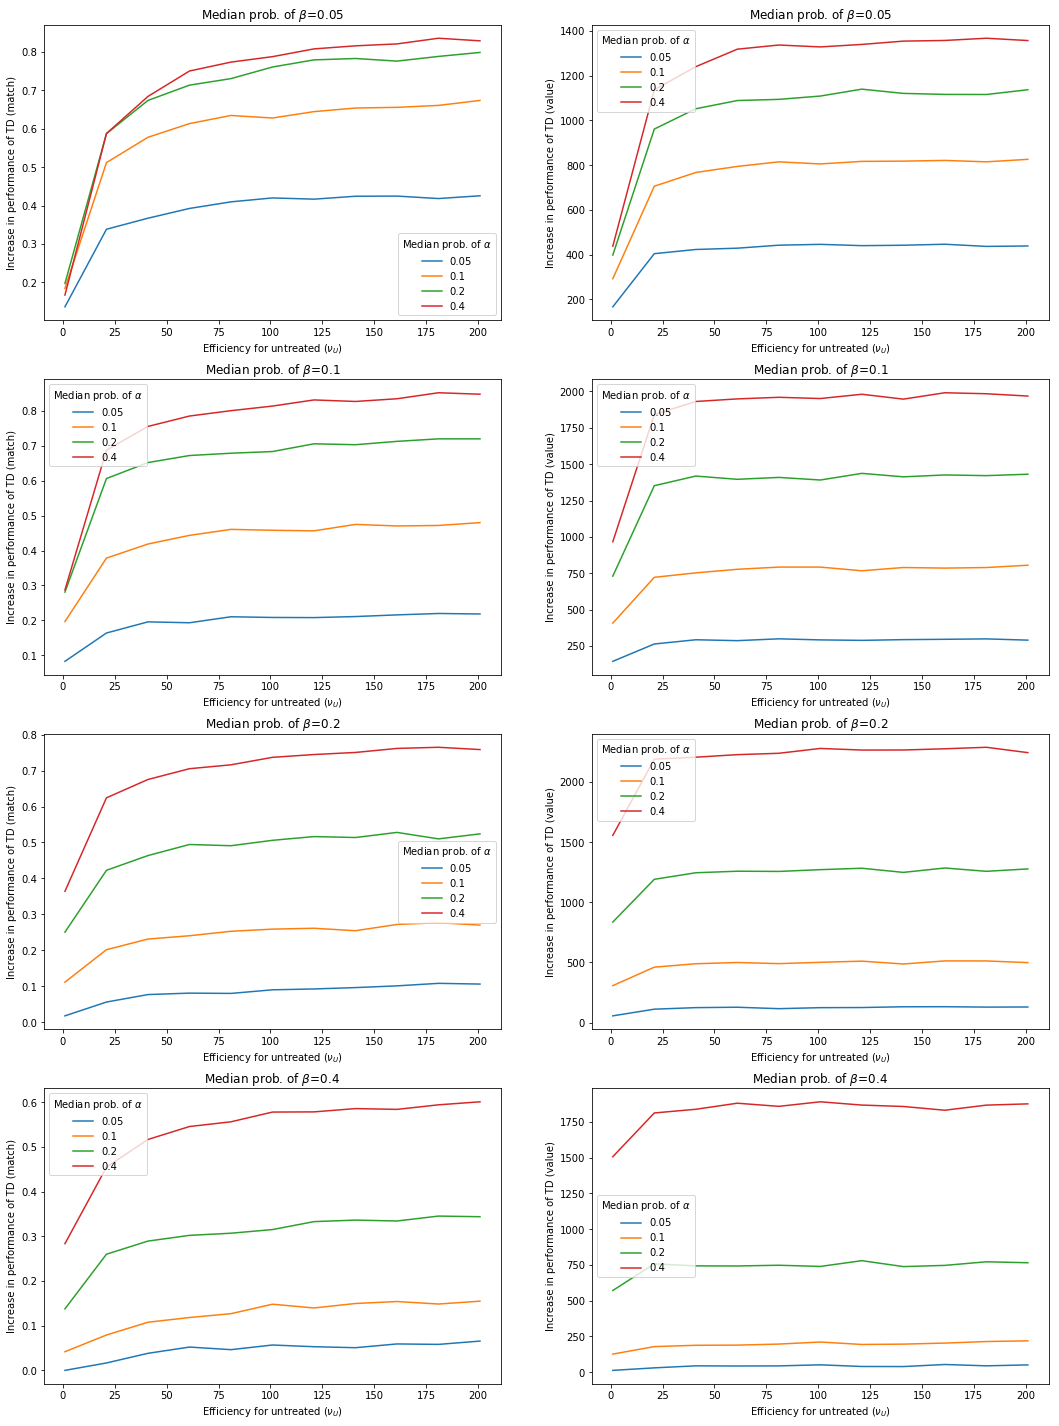

In [8]:
do_robustness_check("size_u", np.array(range(11)) * 20 + 1, r'Efficiency for untreated ($\nu_U$)')

# Robustness check: correlation
The increase in performance of using treatment effects depends on the correlation between the effect and the bias.

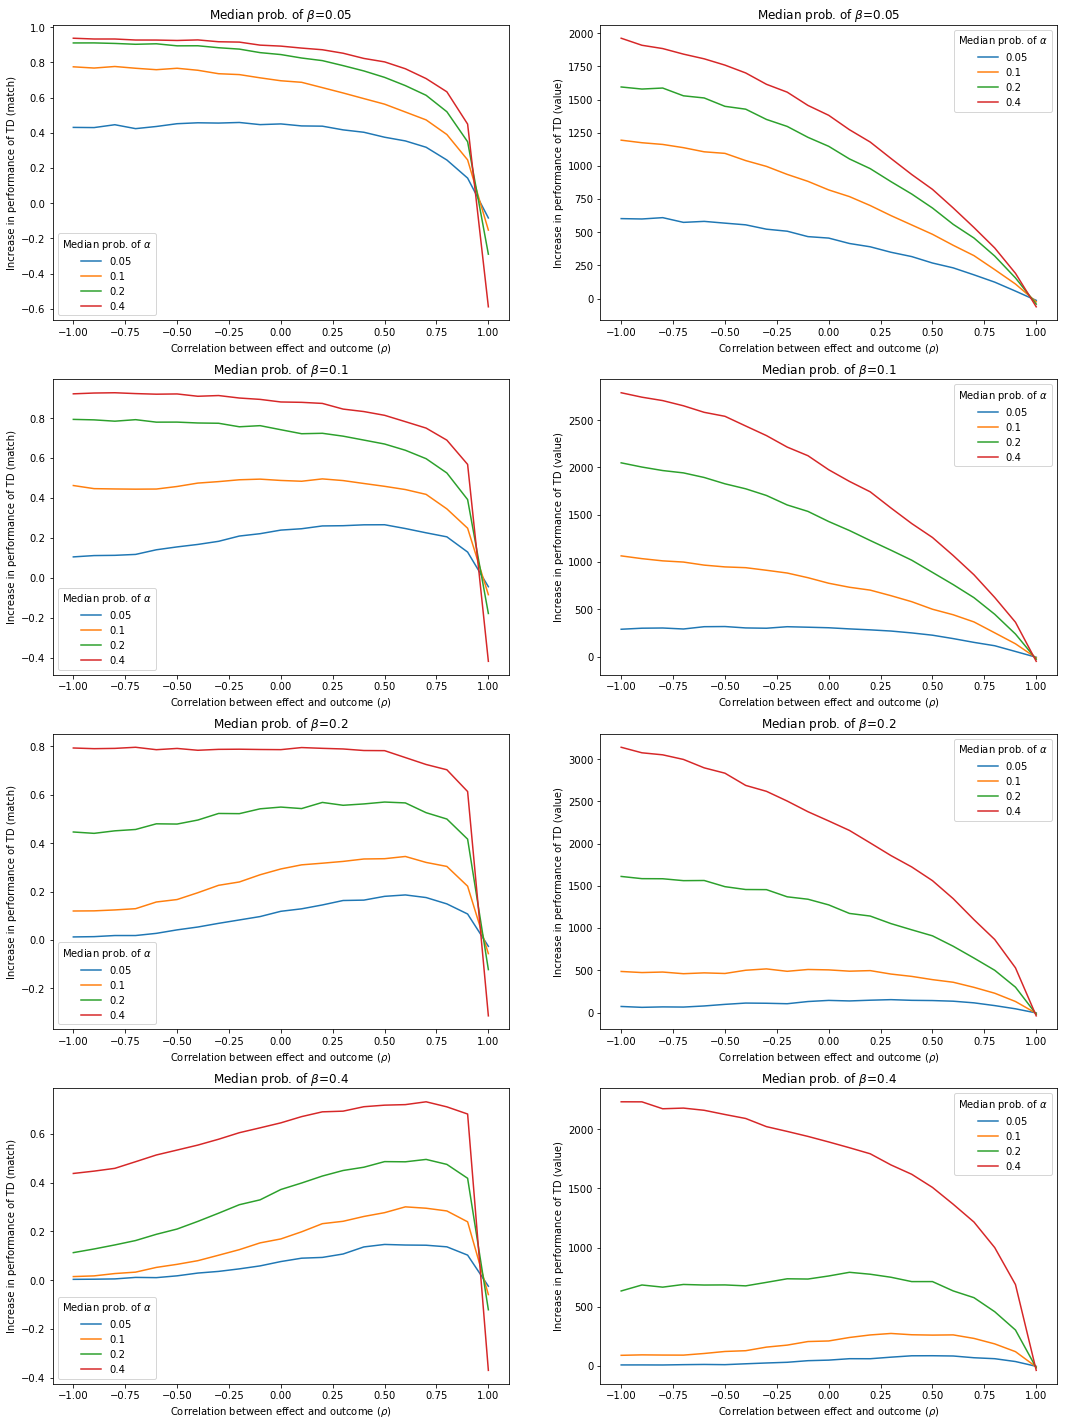

In [9]:
do_robustness_check("corr", np.array(range(-10, 11)) * 0.1, r'Correlation between effect and outcome ($\rho$)')

# Robustness check: distance from decision threshold
The increase in performance of using treatment effects depends on the distance from the decision threshold.

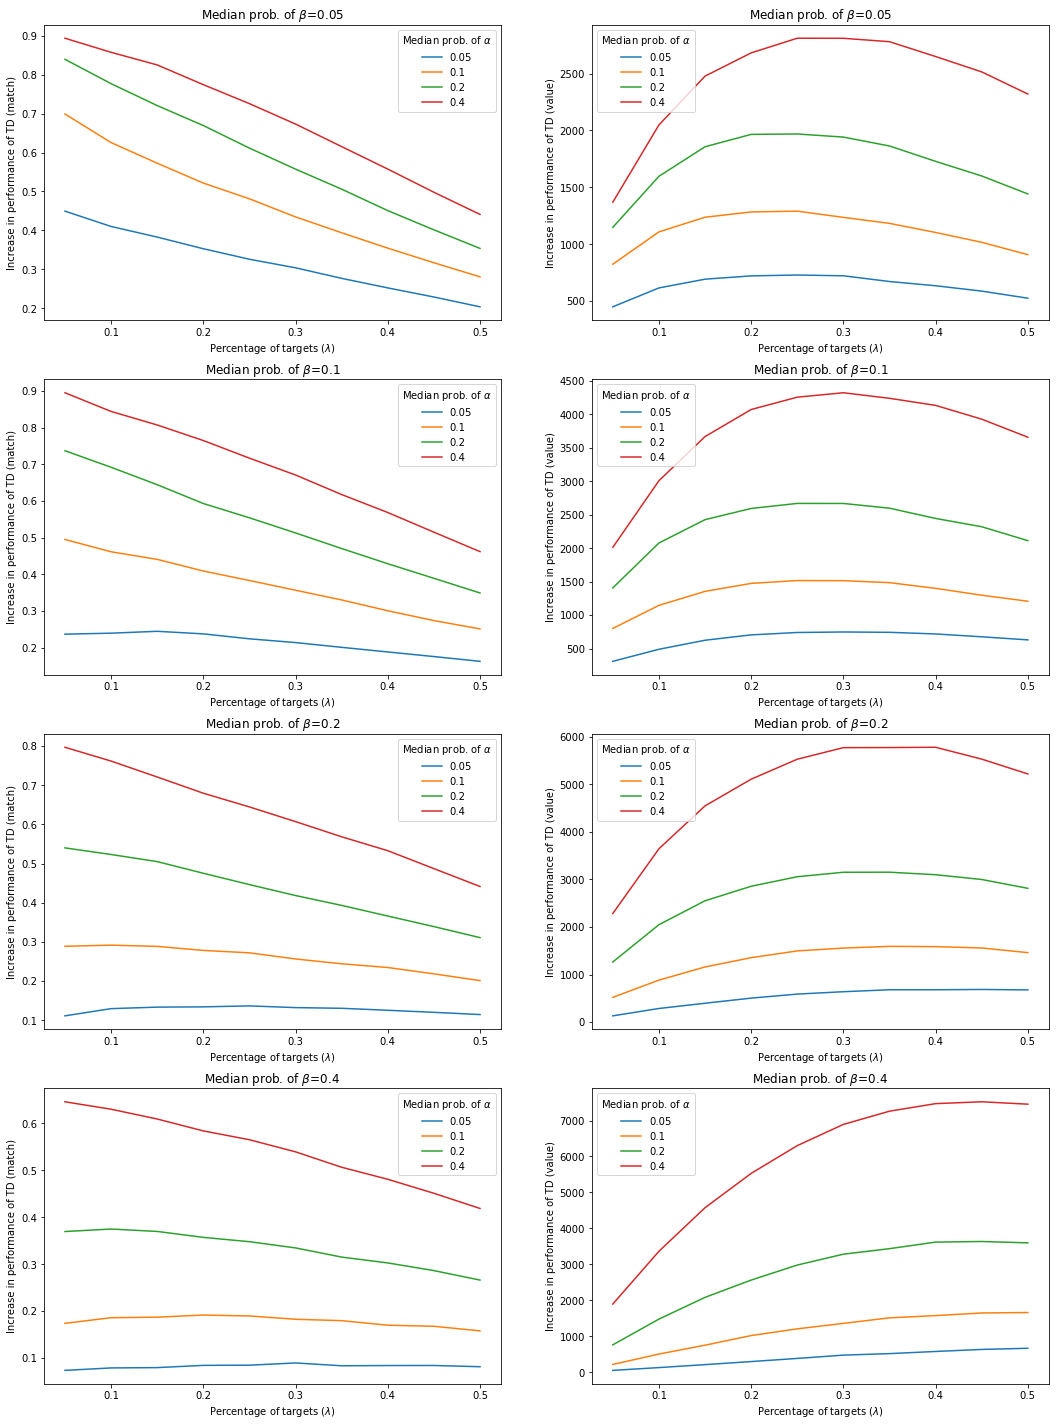

In [10]:
do_robustness_check("target", np.array(range(1, 11)) * 0.05, r'Percentage of targets ($\lambda$)')